In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
from matplotlib import rc
rc('font', family='AppleGothic')
import seaborn as sns
import numpy as np
from collections import Counter

## Colum Description
- store_id : 각 파일에서의 상점 고유 번호.
- date : 거래 일자
- time : 거래 시간
- card_id : 카드 번호의 hash 값
- amount : 매출액, 0보다 작은 음수는 거래 취소(환불), 단위 krw 아님, 할부개월수만큼 amount들어옴
- installments : 할부개월수. 일시불은 빈 문자열
- days_of_week : 요일, 월요일이 0, 일요일은 6
- holyday : 1이면 공휴일, 0이면 공휴일 아님

### Load & Check DataSet

In [2]:
file_dir = '/content/drive/MyDrive/kaggle-study/4/data/'

train = pd.read_csv(file_dir + 'train.csv')
train.shape

(3362796, 8)

In [3]:
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0


In [4]:
train.describe()

,store_id,amount,installments,days_of_week,holyday
count,3.362796e+06,3.362796e+06,16860.000000,3.362796e+06,3.362796e+06
mean,8.323770e+02,1.459623e+02,3.459490,3.066320e+00,4.431283e-02
std,5.468544e+02,6.017306e+02,2.382382,1.976153e+00,2.057892e-01
min,0.000000e+00,-2.500000e+05,2.000000,0.000000e+00,0.000000e+00
25%,3.350000e+02,3.200000e+01,3.000000,1.000000e+00,0.000000e+00
50%,8.220000e+02,7.500000e+01,3.000000,3.000000e+00,0.000000e+00
75%,1.342000e+03,1.500000e+02,3.000000,5.000000e+00,0.000000e+00
max,1.799000e+03,2.500000e+05,36.000000,6.000000e+00,1.000000e+00


## Preprocess
### Remove Outliers
outlier가 있을 수 있다고 판단되는 column을 선택합니다 -> amount

amount column에서 outlier를 찾아 제거합니다

vilolinplot을 이용해 분포 범위를 확인해보겠습니다

In [5]:
train['temp'] = 1

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


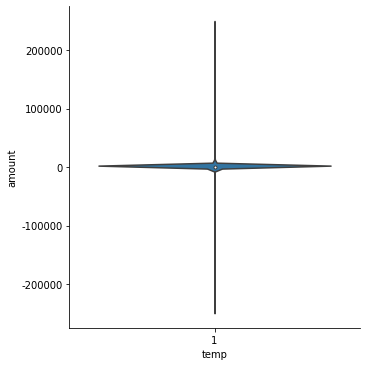

In [6]:
sns.catplot(data=train, x='temp', y='amount', kind='violin')

amount의 분포 범위는 넓은데 반해 분포는 한쪽으로 편중되어 확인이 어렵습니다. 따라서 numpy의 percentile을 이용해 데이터가 차지하는 비율을 확인해보겠습니다

In [7]:
percentage_99 = np.percentile(train["amount"], 99)
print(percentage_99)

1335.0


In [8]:
percentage_98 = np.percentile(train["amount"], 98)
print(percentage_98)

800.0


amount의 최대값은 250000, 최소값은 -250000입니다

데이터의 약 99%가 차지하는 위치의 amount 값은 1335, 98%가 차지하는 위치의 amount 값은 800입니다

이는 대부분의 data가 1000이하에 위치하고 있음을 의미합니다. 따라서 1000 이상, -1000 이하의 값을 outlier로 간주하겠습니다

In [9]:
train = train.loc[(train["amount"] >= -1000) & (train["amount"] <= 1000)]

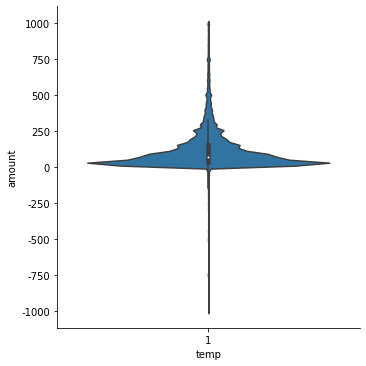

In [10]:
sns.catplot(data=train, x="temp", y="amount", kind="violin")

outlier를 제거하기 전보다 더 고르게 분포하는 것을 확인할 수 있습니다

### Fill in Null Data

null data를 찾아 채워 넣습니다

In [11]:
train.isnull().sum()

store_id              0
date                  0
time                  0
card_id               0
amount                0
installments    3301841
days_of_week          0
holyday               0
temp                  0
dtype: int64

intstallments의 null값은 일시불을 의미하기 때문에, 분할 값 1로 모두 채웠습니다

In [12]:
train.loc[train["installments"].isnull(), "installments"] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [13]:
train.isnull().sum()

store_id        0
date            0
time            0
card_id         0
amount          0
installments    0
days_of_week    0
holyday         0
temp            0
dtype: int64

### Make Total Column
amount는 총액이 할부 단위로 계산한 금액입니다. 따라서 총액을 나타내는 total이라는 컬럼을 생성하겠습니다

total = amount * installments

total은 총 금액을 나타나내는 column

In [14]:
train["total"] = train["amount"] * train["installments"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Data Analysis & Feature Engineering

각각의 column을 분석하기에 앞서 column간의 correlation을 확인해보겠습니다

In [15]:
del train["temp"]

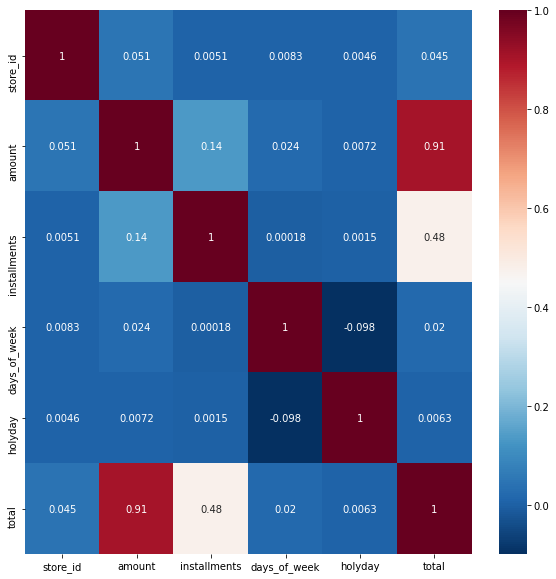

In [16]:
plt.figure(figsize=(10, 10))
sns.heatmap(train[train.columns].corr(), cmap="RdBu_r", annot=True)

### store_id


#### count(거래 기록 기준)
store_id의 countplot을 확인해보겠습니다

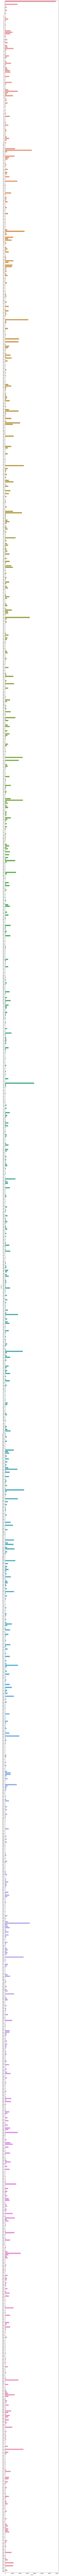

In [17]:
figure, ax = plt.subplots()
figure.set_size_inches(10, 500)
sns.countplot(data=train, y="store_id")

store_id의 숨겨진 경향성을 확인하고자 하였지만, 따로 확인된 것은 없습니다

가게 마다 거래 기록 count 편차가 심하게 난다는 것을 확인할 수 있습니다

store_id의 개수가 1799가 있기 때문에 countplot으로는 확인이 어렵습니다. dataframe 형태로 거래 기록 상위 10개를 확인해보도록 하겠습니다

In [18]:
count_list = []
for i in range(1799):
    train_temp = train.loc[train["store_id"] == i]
    values = {"count" : train_temp.shape[0]}
    count_list.append(values)

In [19]:
count_list[:5]

[{'count': 68715},
 {'count': 7},
 {'count': 16822},
 {'count': 380},
 {'count': 2068}]

In [20]:
count_list = pd.DataFrame.from_dict(count_list)
count_list = count_list.sort_values(by="count", ascending=False)
count_list.index.name = "store_id"

In [21]:
count_list.head(10)

,count
store_id,
0,68715
753,39217
105,35999
1342,33325
428,33281
221,31404
161,26108
1038,25694
323,25219


거래 기록이 많은 기준으로 정렬 했을 때, 상위 10개의 가게를 확인했습니다

가장 많은 거래 기록이 있는 store_id는 0이며, 68715(환불기록 포함)개의 거래가 있었습니다

10번째로 거래 기록이 많은 store_id는 1366이며, 24940개의 거래 기록을 갖고 있습니다

거래 기록 기준 상위 10개의 가게는 유동인구가 많은 곳에 위치해 접근성이 높거나, 충성도 높은 고객을 보유하고 있음을 예측할 수 있습니다

다음으로 거래 기록 기준 하위 10개의 리스트를 확인해보겠습니다

In [22]:
 count_list.tail(10)

,count
store_id,
951,0
617,0
1600,0
601,0
255,0
11,0
1681,0
1216,0
506,0


카드 거래 기록 기준 하위 10개 리스트에는 2016-08-01부터 2018-07-31까지 카드 거래 기록이 단 한 건도 발생하지 않은 가게로 이루어져있습니다

카드 거래 기록이 단 한 건도 발생하지 않은 가게의 수를 확인해보겠습니다

In [23]:
# 기간 중 카드 거래 기록이 단 한 건도 발생하지 않은 가게는 총 55개가 있습니다
count_list_0 = count_list.loc[count_list["count"] == 0]
count_list_0.shape[0]

55

#### total(매출액 기준)

다음으로 매출액 기준 상위 10개의 store_id를 확인해보겠습니다

In [24]:
total_list = []
for i in range(1799):
    train_temp = train.loc[train["store_id"] == i]
    values = {"total" : train_temp["total"].sum()}
    total_list.append(values)

In [25]:
total_list = pd.DataFrame.from_dict(total_list)
total_list = total_list.sort_values(by="total", ascending=False)
total_list.index.name = "store_id"

In [26]:
total_list.head(10)

,total
store_id,
753,9353275.0
1342,7392831.0
0,5318111.0
161,4624716.0
1076,3781650.0
1024,2962918.0
104,2960875.0
1209,2863403.0
597,2787632.0


매출액이 가장 높은 store_id는 753으로 매출액은 9353275입니다

10번째로 매출액이 높은 store_id는 105이며, 매출액은 2563178입니다. 가장 높은 매출액의 약 1/4로 비교적 큰 차이임을 확인할 수 있습니다

거래기록 기준 상위 10개 리스트 중, 5개의 store_id(753, 1342, 0, 161, 105)가 매출액 기준 상위 10개의 리스트에도 포함되어 있음을 확인할 수 있습니다

다음으로 매출액 기준 하위 10개의 리스트를 확인해보겠습니다

In [27]:
total_list.tail(10)

,total
store_id,
601,0.0
1354,0.0
454,0.0
1231,0.0
1530,0.0
1649,0.0
1216,0.0
1582,0.0
1681,0.0


기간 중 카드 거래 기록이 단 한건도 발생하지 않은 가게가 55개 있었기 때문에, 예상대로 매출액 기준 리스트의 하위 10개 가게의 매출액은 모두 0입니다

### date & time
date와 time column을 이용해 year, month, day, hour, minute, second column을 생성합니다


In [28]:
def split_date(date):
    return date.split("-") -> *['1111','11','11']
    

In [77]:
list(zip(['1111','11','11'], 
         ['2222','22','22']))

**dict

[('1111', '2222'), ('11', '22'), ('11', '22')]

In [29]:
train["year"], train["month"], train["day"] = zip(*train['date'].apply(lambda x: split_date(x)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
def split_time(time):
    return time.split(":")

In [31]:
train["hour"], train["minute"], train["second"] = zip(*train['time'].apply(lambda x: split_time(x)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
train["year"] = train["year"].astype(int)
train["month"] = train["month"].astype(int)
train["day"] = train["day"].astype(int)
train["hour"] = train["hour"].astype(int)
train["minute"] = train["minute"].astype(int)
train["second"] = train["second"].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [33]:
# 각 컬럼이 잘 생성되었는지 확인합니다
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,total,year,month,day,hour,minute,second
0,0,2016-12-14,18:05:31,d297bba73f,5,1.0,2,0,5.0,2016,12,14,18,5,31
1,0,2016-12-14,18:05:54,d297bba73f,-5,1.0,2,0,-5.0,2016,12,14,18,5,54
2,0,2016-12-19,12:42:31,0880849c05,144,1.0,0,0,144.0,2016,12,19,12,42,31
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,1.0,0,0,66.0,2016,12,19,12,48,8
4,0,2016-12-19,13:31:08,7ad237eed0,24,1.0,0,0,24.0,2016,12,19,13,31,8


#### year

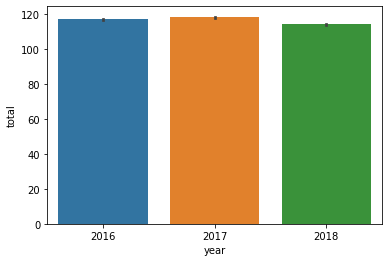

In [34]:
sns.barplot(data=train, x="year", y="total")

연도별 평균 총액을 확인했습니다. 2016년과 2018년은 1년 단위로 집계되지 않은 data이기에 barplot을 이용해 거래 기록 총액의 평균값(total/count)을 이용했습니다

2016년부터 2017년 까지 매출액은 다소 올라갔지만, 2018년 부터 매출액이 이 다소 줄어든 것을 확인할 수 있습니다

#### month

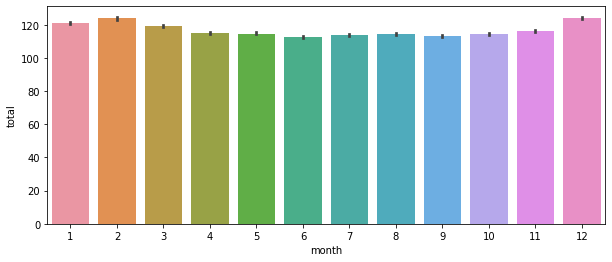

In [35]:
figure, ax = plt.subplots()
figure.set_size_inches(10, 4)
sns.barplot(data=train, x="month", y="total")

월별 평균 총액을 확인했습니다

12월이 가장 높았고, 6월이 가장 낮았습니다

12월은 송년회 및 연말 할인이 빈번하기 때문에 경제 활동이 가장 많다고 예측해 볼 수 있습니다

#### day

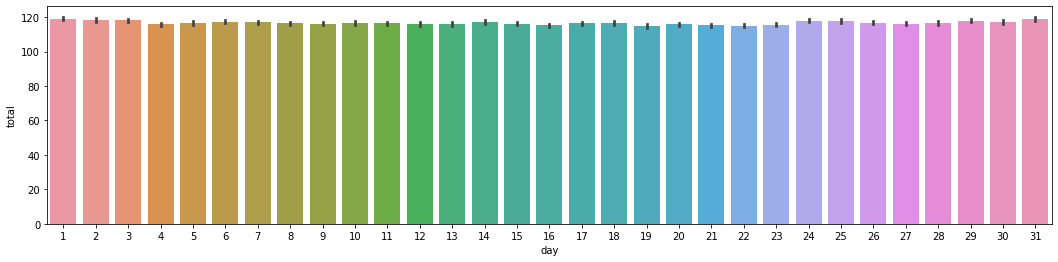

In [36]:
figure, ax = plt.subplots()
figure.set_size_inches(18, 4)
sns.barplot(data=train, x="day", y="total")

24일부터 3일까지 날짜별 평균 매출 총액이 가장 높습니다

이는 경제 활동 인구의 급여가 월 후반에 들어오는 것과 연결되어 있기 때문이라고 판단됩니다

year, month, day 컬럼에 대한 countplot을 한 데 모아 시각화하겠습니다

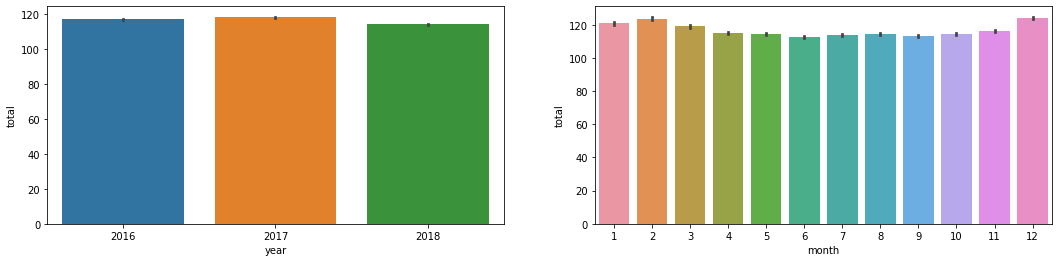

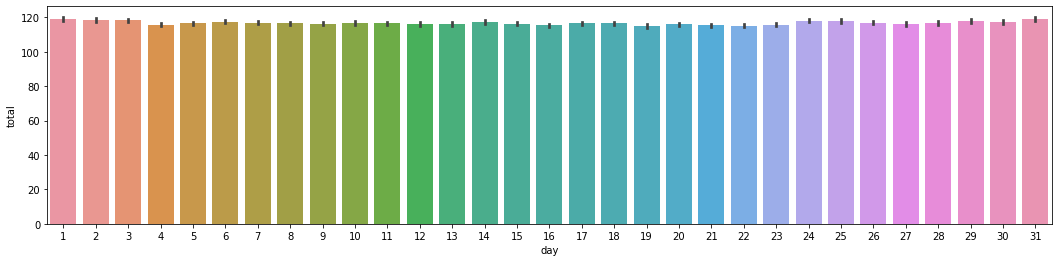

In [37]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)
sns.barplot(data=train, x="year", y="total", ax=ax1)
sns.barplot(data=train, x="month", y="total", ax=ax2)

figure, ax3 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)
sns.barplot(data=train, x="day", y="total", ax=ax3)

#### days_of_week

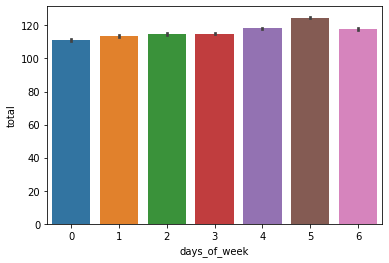

In [38]:
sns.barplot(data=train, x="days_of_week", y="total")

요일별 평균 매출 총액을 확인했습니다

월요일(0)부터 토요일(6)까지 꾸준하게 상승해 토요일에 가장 많은 매출일 일어나는 것을 확인했습니다

토요일과 일요일 모두 주말이지만, 일요일은 토요일에 비해 크게 줄었습니다

요일별 평균 매출 총액을 통해 주말에 경제 활동이 많은 것을 확인했습니다

holyday를 기준으로 요일별 매출 총액을 다시 확인해보겠습니다

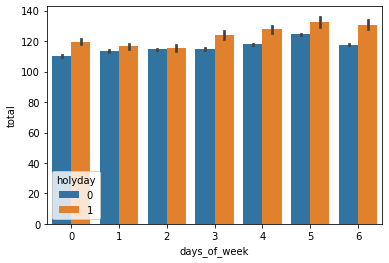

In [39]:
sns.barplot(data=train, x="days_of_week", y="total", hue="holyday")

예측대로 평일에 비해 공휴일에 평균 매출 총액이 높은 것을 확인할 수 있으며, 그 차이는 금(4), 토(5), 일(6)에 더 크게 드러납니다

#### hour

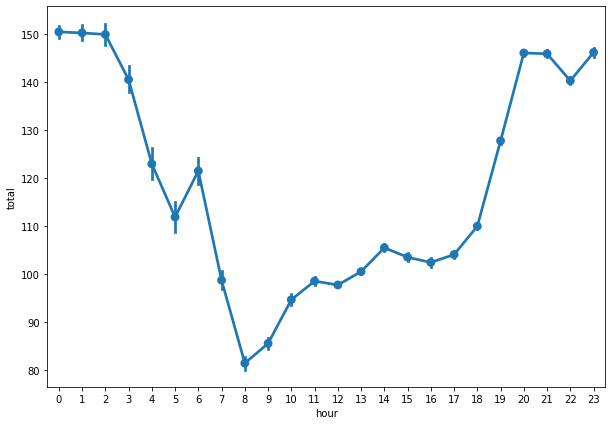

In [40]:
plt.figure(figsize=(10, 7))
sns.pointplot(data=train, x="hour", y="total")

시간별 매출 총액 평균을 pointplot으로 확인했습니다

퇴근 시간인 오후 6시 부터 급격히 상승하기 시작하면서 자정부터 새벽 2시까지 매출액이 가장 높고, 이후로 점차 줄어들면서 오전 8시까지 점차적으로 하락하는 것을 확인할 수 있습니다

요일에 따라 시간별 매출 총액 평균을 확인해보겠습니다

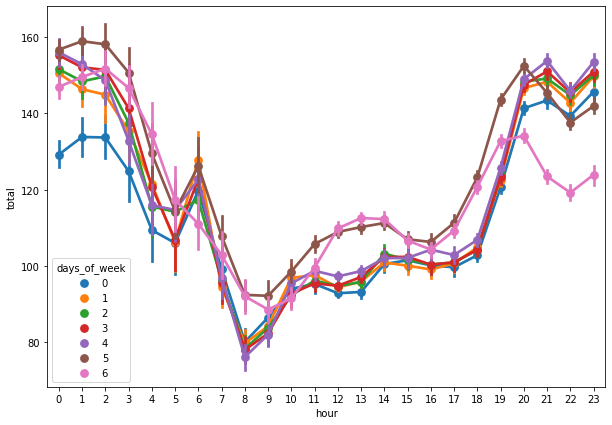

In [41]:
plt.figure(figsize=(10, 7))
sns.pointplot(data=train, x="hour", y="total", hue="days_of_week")

일욜일(6)을 제외한 모든 요일에 대해서 시간별 매출 양상이 비슷하게 나타나고 있습니다

특징적인 것으로는 일요일은 비교적 오후 8시 이후부터 매출액이 감소하고 있습니다. 다음날 출근을 위해 외출을 자제하는 성향에 기인하는 것으로 예측할 수 있습니다

그리고 다른 요일에 비해 월요일은 자정부터 새벽 2시까지의 매출 총액이 다른 요일에 비해 비교적 적습니다. 월요일은 비교적 경제 활동 인구가 빨리 귀가하는 것이라고 판단됩니다

다음으로 공휴일/평일 기준으로 시간별 매출 총액을 확인해보겠습니다

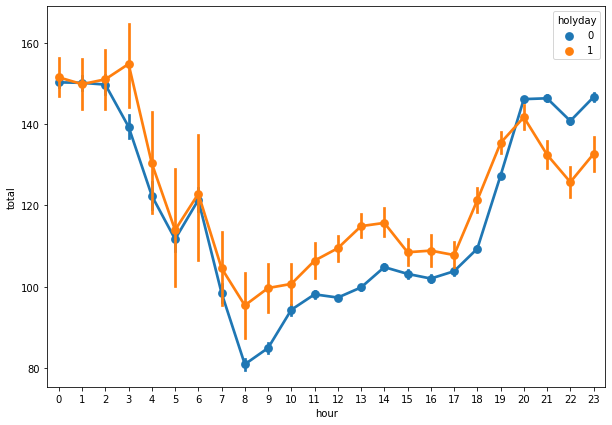

In [42]:
plt.figure(figsize=(10, 7))
sns.pointplot(data=train, x="hour", y="total", hue="holyday")

공휴일의 매출 총액이 평일의 매출 총액보다 전체적으로 높게 위치하고 있음을 알 수 있습니다. 그 차이는 오전 7시부터 오후 7시까지 크게 나타나며, 오후 8시부터 11시 까지는 공휴일의 매출 총액이 큰 차이로 줄어고 있습니다

뿐만 아니라 공휴일의 시간별 매출 총액의 편차는 평일보다 크게 나타납니다. 특히 새벽시간에 그 편차가 크게 나타나고 있는데, 이는 다음날이 쉬는 날인지 여부에 따라 그 값의 차이가 크게 나타나는 것이라고 예측합니다. 이를 확인하기 위해 다음날이 주말 또는 휴일인지를 확인하는 column을 추가해 검증해보도록 하겠습니다.

nextday_holiday컬럼을 생성해 0을 집어 넣고, 다음날이 주말인 경우와 holyday인 경우를 1로 채워 넣겠습니다

금요일과 토요일은 다음날이 주말이기 때문에 우선 nextday_holiday 컬럼을 1로 채워 넣겠습니다

In [43]:
train["nextday_holiday"] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
train.loc[(train["days_of_week"] == 4) | (train["days_of_week"] == 5), "nextday_holiday"] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


다음날이 공휴일인지 확인하기 위해 nextday_year, nextday_month, nextday_day 컬럼을 만들고, 이를 이용해 nextday 컬럼을 채우도록 하겠습니다

In [45]:
# nextday_year 컬럼은 year값을 복사합니다(추후 변경)

train["nextday_year"] = train["year"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
# nextday_month 컬럼은 month값을 복사합니다(추후 변경)
train["nextday_month"] = train["month"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
# nextday_day 컬럼을 만들어 day + 1 값을 입력합니다
train["nextday_day"] = train["day"] + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


day값이 마지막 날짜인 경우, nextday_day값은 1로 채워져야 합니다

연도별, 월별 마지막 날짜를 확인해보겠습니다

데이터 집계가 2016년 8월부터 2018년 7월까지 이기 때문에 아래의 정보만 확인해보겠습니다

------------------------------------------------------------------------------------------
2016년 8월 - 31일, 9월 - 30일, 10월 - 31일, 11월 - 30일, 12월 - 31일

2017년 1월 - 31일, 2월 - 28일, 3월 - 31일, 4월 - 30일, 5월 - 31일, 6월 - 30일, 7월 - 31일, 8월 - 31일, 9월 - 30일, 10월 - 31일, 11월 - 30일, 12월 - 31일

2018년 1월 - 31일, 2월 - 28일, 3월 - 31일, 4월 - 30일, 5월 - 31일, 6월 - 30일, 7월 - 31일, 8월 - 31일

2016년

In [48]:
# 2016년 12월 31일의 다음날은 2017년 1월 1이므로 연도와 월, 날짜 모두 변경되어야 한다
train.loc[(train["nextday_day"] == 32) & (train["year"] == 2016) & (train["month"] == 12), "nextday_year"] = train["year"] + 1
train.loc[(train["nextday_day"] == 32) & (train["year"] == 2016) & (train["month"] == 12), "nextday_month"] = 1

# 마지막 날짜가 31일인 달(12월 제외)
train.loc[(train["nextday_day"] == 32) & (train["year"] == 2016) & ((train["month"] == 8) | (train["month"] == 10) | (train["month"] == 12)), "nextday_day"] = 1
train.loc[(train["nextday_day"] == 32) & (train["year"] == 2016) & ((train["month"] == 8) | (train["month"] == 10)), "nextday_month"] = train["month"] + 1

# 마지막 날짜가 30일인 달
train.loc[(train["nextday_day"] == 31) & (train["year"] == 2016) & ((train["month"] == 9) | (train["month"] == 11)), "nextday_day"] = 1
train.loc[(train["nextday_day"] == 31) & (train["year"] == 2016) & ((train["month"] == 9) | (train["month"] == 11)), "nextday_month"] = train["month"] + 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [49]:
# 2017년 12월 31일의 다음날은 2018년 1월 1이므로 연도와 월, 날짜 모두 변경되어야 한다
train.loc[(train["nextday_day"] == 32) & (train["year"] == 2017) & (train["month"] == 12), "nextday_year"] = train["year"] + 1
train.loc[(train["nextday_day"] == 32) & (train["year"] == 2017) & (train["month"] == 12), "nextday_month"] = 1
# 마지막 날짜가 31일인 달(12월 제외)
train.loc[(train["nextday_day"] == 32) & (train["year"] == 2017) & ((train["month"] == 1) | (train["month"] == 3) | (train["month"] == 5) | (train["month"] == 7) | (train["month"] == 8) | (train["month"] == 10) | (train["month"] == 12)), "nextday_day"] = 1
train.loc[(train["nextday_day"] == 32) & (train["year"] == 2017) & ((train["month"] == 1) | (train["month"] == 3) | (train["month"] == 5) | (train["month"] == 7) | (train["month"] == 8) | (train["month"] == 10)), "nextday_month"] = train["month"] + 1
# 마지막 날짜가 30일인 달
train.loc[(train["nextday_day"] == 31) & (train["year"] == 2017) & ((train["month"] == 4) | (train["month"] == 6) | (train["month"] == 9) | (train["month"] == 11)), "nextday_day"] = 1
train.loc[(train["nextday_day"] == 31) & (train["year"] == 2017) & ((train["month"] == 4) | (train["month"] == 6) | (train["month"] == 9) | (train["month"] == 11)), "nextday_month"] = train["month"] + 1
# 마지막 날짜가 28일인 달
train.loc[(train["nextday_day"] == 29) & (train["year"] == 2017) & (train["month"] == 2), "nextday_day"] = 1
train.loc[(train["nextday_day"] == 29) & (train["year"] == 2017) & (train["month"] == 2), "nextday_month"] = train["month"] + 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [50]:
# 마지막 날짜가 31일인 달
train.loc[(train["nextday_day"] == 32) & (train["year"] == 2017) & ((train["month"] == 1) | (train["month"] == 3) | (train["month"] == 5) | (train["month"] == 7) | (train["month"] == 8)), "nextday_day"] = 1
train.loc[(train["nextday_day"] == 32) & (train["year"] == 2017) & ((train["month"] == 1) | (train["month"] == 3) | (train["month"] == 5) | (train["month"] == 7) | (train["month"] == 8)), "nextday_month"] = train["month"] + 1
# 마지막 날짜가 30일인 달
train.loc[(train["nextday_day"] == 31) & (train["year"] == 2017) & ((train["month"] == 4) | (train["month"] == 6)), "nextday_day"] = 1
train.loc[(train["nextday_day"] == 31) & (train["year"] == 2017) & ((train["month"] == 4) | (train["month"] == 6)), "nextday_month"] = train["month"] + 1
# 마지막 날짜가 28일인 달
train.loc[(train["nextday_day"] == 29) & (train["year"] == 2017) & (train["month"] == 2), "nextday_day"] = 1
train.loc[(train["nextday_day"] == 29) & (train["year"] == 2017) & (train["month"] == 2), "nextday_month"] = train["month"] + 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

nextday_month 컬럼에서 그 값이 한 자리인 경우 앞에 "0"을 추가합니다(기존의 date 형식과 맞추기 위해)

In [51]:
train["nextday_year_str"] = train["nextday_year"].astype(str)
train["nextday_month_str"] = train["nextday_month"].astype(str)
train["nextday_day_str"] = train["nextday_day"].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [52]:
for month in range(1, 10):
    train.loc[(train["nextday_month_str"] == str(month)), "nextday_month_str"] = "0" + str(month)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [53]:
for day in range(10):
    train.loc[(train["nextday_day_str"] == str(day)), "nextday_day_str"] = "0" + str(day)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


nextday_date 컬럼을 생성합니다

In [54]:
train["nextday_date"] = train["nextday_year_str"] + "-" + train["nextday_month_str"] + "-" + train["nextday_day_str"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


nextday_date컬럼과 date컬럼을 비교해 확인합니다

In [55]:
train[["date", "nextday_date"]].head()

,date,nextday_date
0,2016-12-14,2016-12-15
1,2016-12-14,2016-12-15
2,2016-12-19,2016-12-20
3,2016-12-19,2016-12-20
4,2016-12-19,2016-12-20


holyday가 1인 경우를 train_holiday로 저장합니다

In [56]:
train_holiday = train.loc[train["holyday"] == 1]

In [57]:
print(train_holiday.shape)
train_holiday.head()

(147622, 23)


,store_id,date,time,card_id,amount,installments,days_of_week,holyday,total,year,month,day,hour,minute,second,nextday_holiday,nextday_year,nextday_month,nextday_day,nextday_year_str,nextday_month_str,nextday_day_str,nextday_date
772,0,2016-12-25,00:23:22,7df04debf0,79,1.0,6,1,79.0,2016,12,25,0,23,22,0,2016,12,26,2016,12,26,2016-12-26
773,0,2016-12-25,00:34:09,0cd162eeb9,151,1.0,6,1,151.0,2016,12,25,0,34,9,0,2016,12,26,2016,12,26,2016-12-26
774,0,2016-12-25,01:11:57,3c62f0c4fd,38,1.0,6,1,38.0,2016,12,25,1,11,57,0,2016,12,26,2016,12,26,2016-12-26
775,0,2016-12-25,01:19:19,5d6c78f689,14,1.0,6,1,14.0,2016,12,25,1,19,19,0,2016,12,26,2016,12,26,2016-12-26
776,0,2016-12-25,01:22:11,5d6c78f689,25,1.0,6,1,25.0,2016,12,25,1,22,11,0,2016,12,26,2016,12,26,2016-12-26


train_holiday의 date값을 중복되지 않게 list로 만듭니다

In [58]:
my_list = train_holiday["date"].values
uniqueVals = np.unique(my_list)
holiday_date_list = uniqueVals.tolist()

In [59]:
holiday_date_list

['2016-08-15',
 '2016-09-14',
 '2016-09-15',
 '2016-09-16',
 '2016-10-03',
 '2016-10-09',
 '2016-12-25',
 '2017-01-01',
 '2017-01-27',
 '2017-01-28',
 '2017-01-29',
 '2017-01-30',
 '2017-03-01',
 '2017-05-01',
 '2017-05-03',
 '2017-05-05',
 '2017-05-09',
 '2017-06-06',
 '2017-08-15',
 '2017-10-02',
 '2017-10-03',
 '2017-10-04',
 '2017-10-05',
 '2017-10-06',
 '2017-10-09',
 '2017-12-25',
 '2018-01-01',
 '2018-02-15',
 '2018-02-16',
 '2018-02-17',
 '2018-03-01',
 '2018-05-01',
 '2018-05-05',
 '2018-05-07',
 '2018-05-22',
 '2018-06-06',
 '2018-06-13']

train 데이터의 nextday_date값이 holiday_date_list에 속해있으면, nextday_holiday컬럼의 값을 1로 채웁니다

In [60]:
idx = [idx for idx, value in enumerate(train["nextday_date"]) if value in holiday_date_list]

In [74]:
# 출력을 위해 한듯 아래와 같이 한듯...?
train.loc[idx, "nextday_holiday"].apply(lambda x : 1)
train.ix[]
.iloc
.loc

KeyError: ignored

In [65]:
train.iloc[idx]

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,total,year,month,day,hour,minute,second,nextday_holiday,nextday_year,nextday_month,nextday_day,nextday_year_str,nextday_month_str,nextday_day_str,nextday_date
625,0,2016-12-24,00:02:38,fd4156ee2a,52,1.0,5,0,52.0,2016,12,24,0,2,38,1,2016,12,25,2016,12,25,2016-12-25
626,0,2016-12-24,01:03:57,f2fc61ff42,72,1.0,5,0,72.0,2016,12,24,1,3,57,1,2016,12,25,2016,12,25,2016-12-25
627,0,2016-12-24,01:25:19,90f20f878b,52,1.0,5,0,52.0,2016,12,24,1,25,19,1,2016,12,25,2016,12,25,2016-12-25
628,0,2016-12-24,01:32:11,7768ddbe11,94,1.0,5,0,94.0,2016,12,24,1,32,11,1,2016,12,25,2016,12,25,2016-12-25
629,0,2016-12-24,01:33:07,7768ddbe11,118,1.0,5,0,118.0,2016,12,24,1,33,7,1,2016,12,25,2016,12,25,2016-12-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362694,1799,2018-02-14,15:16:54,b783571daf,350,1.0,2,0,350.0,2018,2,14,15,16,54,0,2018,2,15,2018,02,15,2018-02-15
3362695,1799,2018-02-14,15:54:36,8b8921f03c,375,1.0,2,0,375.0,2018,2,14,15,54,36,0,2018,2,15,2018,02,15,2018-02-15
3362696,1799,2018-02-14,18:39:32,fb942a7fed,325,1.0,2,0,325.0,2018,2,14,18,39,32,0,2018,2,15,2018,02,15,2018-02-15
3362697,1799,2018-02-15,10:10:28,affdcbc082,300,1.0,3,1,300.0,2018,2,15,10,10,28,0,2018,2,16,2018,02,16,2018-02-16


nextday_holiday에 따라 시간별 평균 매출 총액을 pointplot으로 확인합니다

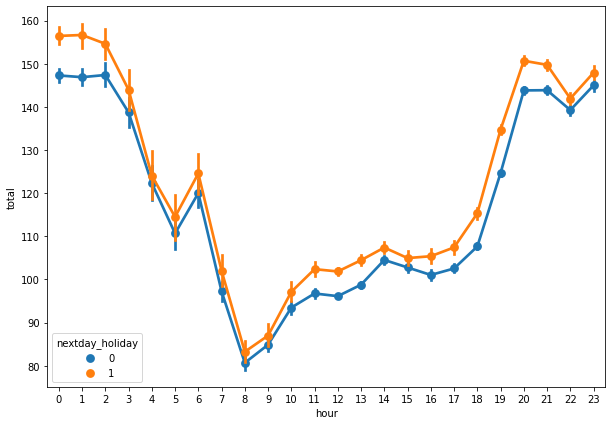

In [66]:
plt.figure(figsize=(10, 7))
sns.pointplot(data=train, x="hour", y="total", hue="nextday_holiday")

이 그래프를 통해 holyday기준으로 시간별 매출 총액을 나타냈을 때보다 뚜렷하게 확인할 수 있는 몇 가지 사실이 있습니다

첫째로, 모든 시간에 대해 다음날이 휴일인 경우의 매출 총액이 높게 나온다는 점입니다. 특히 늦은 저녁 및 새벽 시간에 그 차이가 크다는 것을 확인할 수 있습니다.

둘째로, 시간별 매출 총액의 편차(point의 bar)가 holyday기준 그래프보다 훨씬 작다는 것을 확인할 수 있습니다. 따라서 타겟 컬럼에 따라 holyday를 기준으로 구분할 것인지, nextday_holiday를 기준으로 구분할 것인지 선택한다면 좋은 결과를 얻을 수 있을 것이라 생각합니다

이해를 돕기 위해 두 가지 그래프를 모아보겠습니다

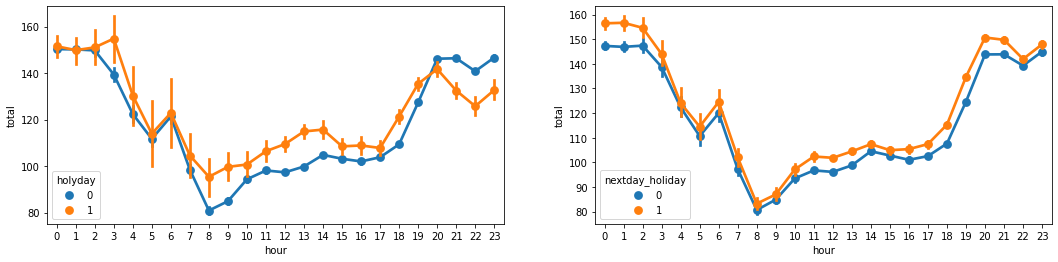

In [67]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)
sns.pointplot(data=train, x="hour", y="total", hue="holyday", ax=ax1)
sns.pointplot(data=train, x="hour", y="total", hue="nextday_holiday", ax=ax2)

### amount

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


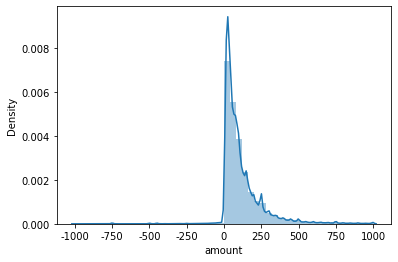

In [68]:
sns.distplot(train["amount"])

amount 컬럼의 분포를 확인해보았습니다. 환불 기록을 제외하고 대부분의 매출액은 150 이하에서 일어나고 있음을 확인할 수 있습니다. 환불 기록을 제외하고 분포를 살펴보도록 하겠습니다

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


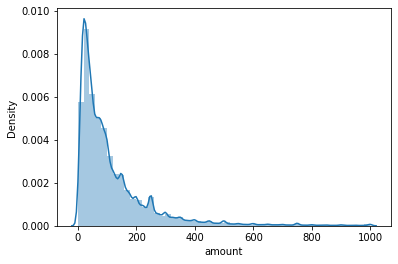

In [69]:
train_over0 = train.loc[train["amount"] >= 0]
sns.distplot(train_over0["amount"])

amount의 분포 범위를 0이상으로 제한시켰습니다. 매출액의 분포 범위를 좀 더 정확히 확인 가능합니다

20~40 영역에서 가장 많은 매출 기록이 있으며, 매출액의 대부분은 100이하임을 확인할 수 있습니다

amount 컬럼은 좌편향 되어 있기 때문에 이를 model에 적용할 경우 normalize를 할 필요가 있습니다

이를 위해 log transformation을 이용합니다

In [70]:
train_over0["amount_plus_one"] = (train_over0["amount"]) + 1
train_over0["log_amount"] = (np.log(train_over0["amount_plus_one"]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


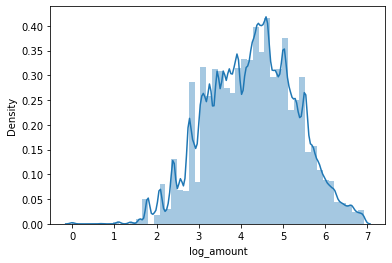

In [71]:
sns.distplot(train_over0["log_amount"])

### total, installments

total 컬럼의 값이 0 이상인 경우에 한해 total과 instamllments의 상관 관계를 확인해보겠습니다

In [72]:
total_over0 = train.loc[train["total"] >= 0]

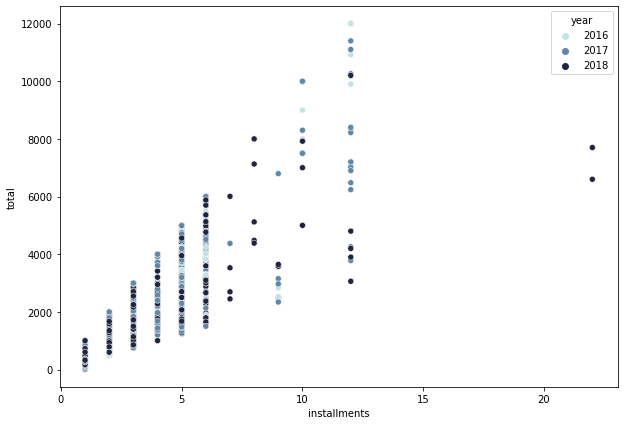

In [73]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
plt.figure(figsize=(10, 7))
sns.scatterplot(data=total_over0, x="installments", y="total", hue="year", palette=cmap)

total과 installments의 상관관계를 scatterplot을 이용해 확인해보았습니다

total 총액이 높을 수록 계산의 분할 횟수가 높게 나타나는 것을 확인할 수 있습니다

높은 금액을 한 번에 지불하기 어렵기 때문에 두 변수 사이의 비례 관계가 나타났다고 생각합니다